<a href="https://colab.research.google.com/github/Minh-A/Dacon_ArcticSeaIce_Prediction/blob/main/Dacon_Code_8_SemiFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt

from tqdm import tqdm  # 진행표시바

from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2차 데이터
fn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data2/train_v2.csv')
fn.tail()

,month,file_nm
489,2019-08,201908.npy
490,2019-09,201909.npy
491,2019-10,201910.npy
492,2019-11,201911.npy
493,2019-12,201912.npy


In [ ]:
# 데이터 불러오기
# 2000년도부터
dm = fn.iloc[255:,1]
dm.shape

(239,)

In [ ]:
# 데이터 생성
data = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data2/train_data_v2/200001.npy')
data = data.reshape(1,448,304,5)

for i in tqdm(dm):
    a = np.load('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data2/train_data_v2/'+i)
    a = a.reshape(1,448,304,5)

    data = np.concatenate((data,a), axis=0)
data = np.array(data)
data = data[:,:,:,0]

data.shape

100%|██████████| 239/239 [00:53<00:00,  4.45it/s]


(240, 448, 304)

In [ ]:
# 월별 데이터 셋 만들기

# 데이터 셋 형태 변환
data = data.reshape(240,1, 448,304)

# 월별로 데이터 셋 생성
for i in tqdm(range(12)):
  globals()['train{}'.format(i)] = np.array(np.concatenate((data[0+i], data[12+i], data[24+i], data[36+i], data[48+i], data[60+i], data[72+i], data[84+i], data[96+i], data[108+i], data[120+i],
                                                            data[132+i], data[144+i], data[156+i], data[168+i], data[180+i], data[192+i], data[204+i], data[216+i], data[228+i]), axis=0))

  print("\n",globals()['train{}'.format(i)].shape)  # globals()는 그 변수를 의미 - 없으면 그냥 문자열

100%|██████████| 12/12 [00:00<00:00, 238.14it/s]


 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)

 (20, 448, 304)


## 함수

In [ ]:
def show(npy):
    num_channel = npy.shape[0]
    plt.figure(figsize=(50, 50)) 
    for channel in range(num_channel):
      tmpimg = npy[channel, :, :]
      ax = plt.subplot(1, num_channel, channel+1)  # (행, 열, 데이터 개수) - 그리고 싶은 팜플렛
      ax.title.set_text("Ice")

      ax.imshow(tmpimg)
    plt.tight_layout()
    plt.show()
    plt.close()

In [ ]:
# 소숫점 둘째 자리 반올림
def fun1(x) : 
  return np.around(x,2)

In [ ]:
# 점수 계산
def mae_score(true, pred):
    score = np.mean(np.abs(true-pred))
    
    return score

def f1_score(true, pred):
    target = np.where((true>250*0.05)&(true<250*0.5))
    
    true = true[target]
    pred = pred[target]
    true = np.where(true < 250*0.15, 0, 1)
    pred = np.where(pred < 250*0.15, 0, 1)
    
    right = np.sum(true * pred == 1)
    precision = right / np.sum(true+1e-8)
    recall = right / np.sum(pred+1e-8)
    score = 2 * precision*recall/(precision+recall+1e-8)
    
    return score
    
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae/(f1+1e-8)
    
    return score

# 테스팅

In [ ]:
# 훈련데이터 12개만
x_train = train10[5:17].reshape( 12,-1).T
y_train = train10[17].reshape(1,-1).T  # 변동없음
x_test = train10[6:18].reshape( 12,-1).T
real = train10[18]  # 변동없음

# K값을 찾아 1
from sklearn.neighbors import KNeighborsRegressor

num = [610, 620]

for i in tqdm(num):
  print(i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print( "MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/2 [00:00<?, ?it/s]

610


 50%|█████     | 1/2 [08:14<08:14, 494.06s/it]

MAE : 2.8961049107142856 
 F1 : 0.6705146510547739 
 Final 4.319226825194959
620


100%|██████████| 2/2 [16:22<00:00, 491.06s/it]

MAE : 2.896624691611842 
 F1 : 0.6706759487799796 
 Final 4.318963060612855


600일때 4.317515622617064

In [ ]:
# 두달을 합쳐서...1

a = train0[5:17].reshape( 12,-1).T
b = train1[5:17].reshape( 12,-1).T

x_train = np.array(np.concatenate((a, b), axis=0))

a1 = train0[17].reshape( 1,-1).T
b1 = train1[17].reshape( 1,-1).T

y_train = np.array(np.concatenate((a1, b1), axis=0))

a2 = train0[6:18].reshape( 12,-1).T
b2 = train1[6:18].reshape( 12,-1).T

x_test = np.array(np.concatenate((a2, b2), axis=0))

a3 = train0[18].reshape( 1,-1).T
b3 = train1[18].reshape( 1,-1).T

real = np.array(np.concatenate((a3, b3), axis=0))

In [ ]:
# 두달을 합쳐서...2

model = KNeighborsRegressor(n_neighbors= 600, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

pre = model.predict(x_test)
pre = pre.reshape(-1)
  
print("MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

MAE : 3.20470604000235 
 F1 : 0.7732395639215335 
 Final 4.144518915075027


In [ ]:
# 두달을 합쳐서...3

model = KNeighborsRegressor(n_neighbors= 450, weights='distance', p=1, n_jobs=-1)
model.fit(x_train, y_train)

pre = model.predict(x_test)
pre = pre.reshape(-1)
  
print("MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
      '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
      '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

MAE : 3.2161620726621236 
 F1 : 0.7771839487904788 
 Final 4.138224980437571


In [ ]:
# 두달을 합쳐서...4
# K값을 찾아서
from sklearn.neighbors import KNeighborsRegressor

k_value = [300, 400, 500, 700, 800]

for i in tqdm(k_value):
  print('\n',i)
  model = KNeighborsRegressor(n_neighbors= i, weights='distance', p=1, n_jobs=-1)
  model.fit(x_train, y_train)

  pre = model.predict(x_test)
  pre = pre.reshape(-1)
  
  print("MAE : %s" % mae_score(real.reshape(-1), fun1(pre)),
        '\n F1 : %s' % f1_score(real.reshape(-1), fun1(pre)),
        '\n Final %s' % mae_over_f1(real.reshape(-1), fun1(pre)))

  0%|          | 0/5 [00:00<?, ?it/s]


 300


 20%|██        | 1/5 [26:52<1:47:28, 1612.14s/it]

MAE : 3.2450251850328944 
 F1 : 0.7795880542254585 
 Final 4.162487003000633

 400


 40%|████      | 2/5 [54:18<1:21:06, 1622.27s/it]

MAE : 3.2230874794407898 
 F1 : 0.7780400022076878 
 Final 4.142572912536056

 500


 60%|██████    | 3/5 [1:21:39<54:15, 1627.89s/it]

MAE : 3.2114388510338348 
 F1 : 0.7772404384995207 
 Final 4.131847303152565

 700


 80%|████████  | 4/5 [1:49:28<27:20, 1640.50s/it]

MAE : 3.2016913621945493 
 F1 : 0.7713367025971404 
 Final 4.150834920607173

 800


100%|██████████| 5/5 [2:17:44<00:00, 1652.84s/it]

MAE : 3.2004722377232144 
 F1 : 0.7683991500780851 
 Final 4.165116783050596


# 메인: KNNR

## 2019년 예측

  0%|          | 0/12 [00:00<?, ?it/s]

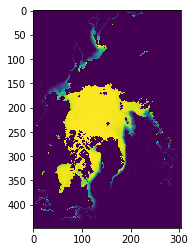

  8%|▊         | 1/12 [06:51<1:15:28, 411.72s/it]

(136192,)


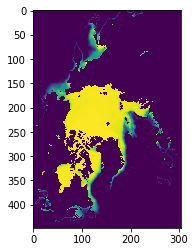

 17%|█▋        | 2/12 [13:37<1:08:19, 409.99s/it]

(136192,)


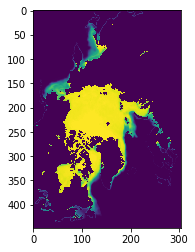

 25%|██▌       | 3/12 [20:18<1:01:05, 407.33s/it]

(136192,)


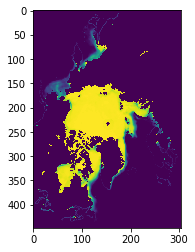

 33%|███▎      | 4/12 [27:16<54:44, 410.52s/it]  

(136192,)


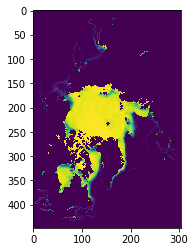

 42%|████▏     | 5/12 [34:30<48:42, 417.47s/it]

(136192,)


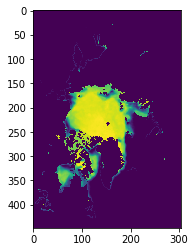

 50%|█████     | 6/12 [42:00<42:43, 427.18s/it]

(136192,)


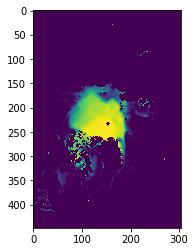

 58%|█████▊    | 7/12 [50:01<36:57, 443.54s/it]

(136192,)


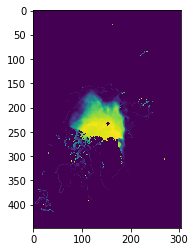

 67%|██████▋   | 8/12 [58:30<30:52, 463.10s/it]

(136192,)


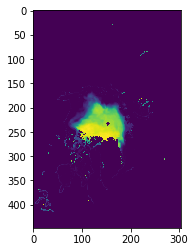

 75%|███████▌  | 9/12 [1:07:10<24:00, 480.09s/it]

(136192,)


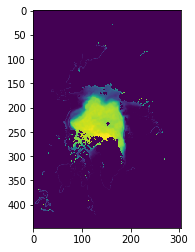

 83%|████████▎ | 10/12 [1:15:12<16:01, 480.64s/it]

(136192,)


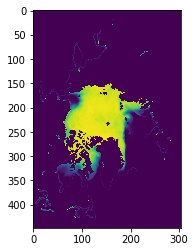

 92%|█████████▏| 11/12 [1:22:40<07:51, 471.03s/it]

(136192,)


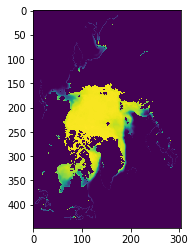

100%|██████████| 12/12 [1:29:38<00:00, 448.17s/it]

(136192,)


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[6:18].reshape(12,-1).T 
  y_train = datan[18].reshape(1,-1).T
  x_test = datan[7:19].reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) 
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred{}'.format(i)] = predictions
  print(globals()['pred{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh1 = pd.DataFrame(pred0.reshape(1,-1))  # 초기값 설정
sh1 = fun1(sh1)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred{}'.format(i+1)] = globals()['pred{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh1 = pd.concat((sh1, sh), axis=0)
  print(sh1.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


In [ ]:
# 1차 데이터 확인 (Pre-제출본)
sh1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2020년 예측

  0%|          | 0/12 [00:00<?, ?it/s]

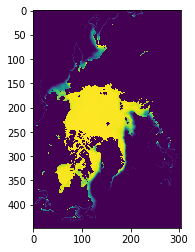

  8%|▊         | 1/12 [07:17<1:20:07, 437.02s/it]

(136192,)


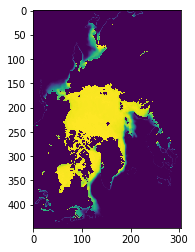

 17%|█▋        | 2/12 [14:27<1:12:31, 435.18s/it]

(136192,)


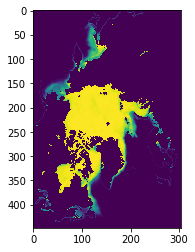

 25%|██▌       | 3/12 [21:37<1:05:00, 433.41s/it]

(136192,)


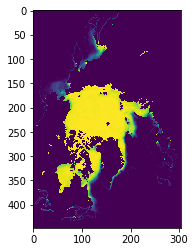

 33%|███▎      | 4/12 [28:52<57:50, 433.87s/it]  

(136192,)


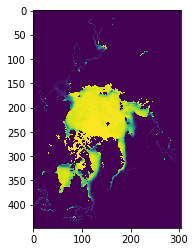

 42%|████▏     | 5/12 [36:33<51:35, 442.17s/it]

(136192,)


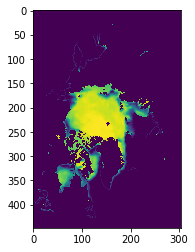

 50%|█████     | 6/12 [44:34<45:23, 453.89s/it]

(136192,)


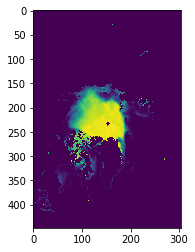

 58%|█████▊    | 7/12 [53:04<39:13, 470.69s/it]

(136192,)


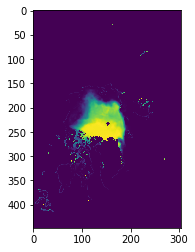

 67%|██████▋   | 8/12 [1:01:55<32:34, 488.69s/it]

(136192,)


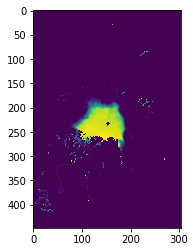

 75%|███████▌  | 9/12 [1:11:08<25:23, 507.86s/it]

(136192,)


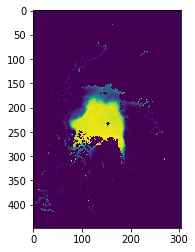

 83%|████████▎ | 10/12 [1:19:31<16:52, 506.39s/it]

(136192,)


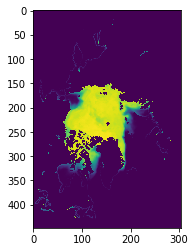

 92%|█████████▏| 11/12 [1:27:20<08:15, 495.42s/it]

(136192,)


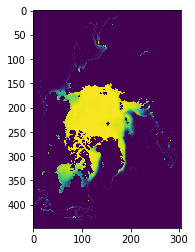

100%|██████████| 12/12 [1:34:56<00:00, 474.75s/it]

(136192,)


In [ ]:
# 기본
from sklearn.neighbors import KNeighborsRegressor

for i in tqdm(range(12)):
  datan = globals()['train{}'.format(i)]

  # 데이터셋 나누기
  x_train = datan[7:19].reshape(12,-1).T  # 600
  y_train = datan[19].reshape(1,-1).T
  x_test = datan[8:20].reshape(12,-1).T

  # 모델 훈련
  model = KNeighborsRegressor(n_neighbors=601, weights='distance', p=1, n_jobs=-1) 
  model.fit(x_train, y_train)

  # 모델 예측
  predictions = model.predict(x_test)
  predictions = predictions.reshape(-1)

  # 그래프를 보자구
  plt.imshow(predictions.reshape(448,304), interpolation = 'None')
  plt.show()

  # 변수 저장
  globals()['pred_{}'.format(i)] = predictions
  print(globals()['pred_{}'.format(i)].shape)

In [ ]:
# 기본
# 제출 형태로 변환

# 데이터 생성
sh2 = pd.DataFrame(pred_0.reshape(1,-1))  # 초기값 설정
sh2 = fun1(sh2)  # 음수와 소숫점 없애기

for i in range(11):
  globals()['pred_{}'.format(i+1)] = globals()['pred_{}'.format(i+1)].reshape(1,-1)

  sh = globals()['pred_{}'.format(i+1)]
  sh = fun1(sh)  # 음수와 소숫점 없애기
  sh = pd.DataFrame(sh)

  sh2 = pd.concat((sh2, sh), axis=0)
  print(sh2.shape)

(2, 136192)
(3, 136192)
(4, 136192)
(5, 136192)
(6, 136192)
(7, 136192)
(8, 136192)
(9, 136192)
(10, 136192)
(11, 136192)
(12, 136192)


In [ ]:
# 1차 데이터 확인 (Pre-제출본)
sh2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 제출

In [ ]:
# sh1의 인덱스 수정

# 12개월, 24개월 투투
result = pd.concat([sh1,sh2], axis=0)
result = result.reset_index(drop=True)

# 제출 파일과 결합
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/data/sample_submission.csv")
sub = pd.concat([submission.loc[:,'month'],result], axis=1)
sub.columns = submission.columns.values  # 제출파일에서 컬럼명을 
sub.tail()

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
19,2020-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,2020-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2020-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2020-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2020-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Lets Final Check')

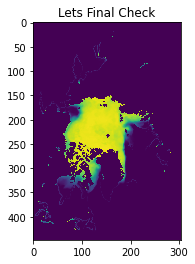

In [ ]:
# 2차 데이터 확인 (최종 제출본)
check = np.array(sub.iloc[10,1:], dtype=np.float64).reshape(448,304)

import matplotlib.pyplot
matplotlib.pyplot.imshow(check, interpolation = 'None')
matplotlib.pyplot.title('Lets Final Check')

In [ ]:
# 제출파일 완성 및 제출
sub.to_csv('/content/drive/MyDrive/Colab Notebooks/DACON 1등이 목표/result/sub_0407_1_KNN.csv', index = False)